In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import gridspec
import matplotlib.animation as manimation
import time
import scipy.io as sio
from random import shuffle
import time
from collections import Counter
import sklearn.cluster as cluster
import time
import hdbscan
from os import listdir
from os.path import isfile, join
import os
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

#import plotly. as py
#import plotly.graph_objs as go
font = {'family' : 'DejaVu Sans',
        'weight' : 'regular',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines',lw=2)

# dereks function for optimal leaf clustering
def _optimal_order(data, **kwargs):
    """ Optimal leaf ordering
        **kwargs passed to pdist e.g. metric='correlation'
    """
    d = pdist(data, **kwargs)
    link = linkage(d, method='average')
    optimal_order = optimal_leaf_ordering(link, d)
    return optimal_order

from scipy.spatial.distance import pdist, squareform
#from fastcluster import linkage
#from polo import optimal_leaf_ordering

from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
def uniqueValsdf(df):
    uniquelist = list(df.iloc[:,0].dropna().unique())
    for col in range(1,len(df.columns)):
        uniquelist = uniquelist+list(df.iloc[:,col].dropna().unique())
    return(uniquelist)

# Heatmap gene stuff

In [11]:
COGcat = pd.read_table('COGreffiles/fun2003-2014.tab')
COGtab = pd.read_table('COGreffiles/cognames2003-2014.tab')
COGtab['NameNum'] = COGtab['name']+' - '+COGtab['COG']
COGtab['FuncCat'] = [COGcat[COGcat['# Code']==i[0]]['Name'].values[0] for i in COGtab['func']]

In [12]:
mypath = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/'
foldernames = [f for f in listdir(mypath) if ('Knumbers') not in f and ('NN_MAGs') not in f]

foldername = pd.DataFrame(index=range(len(foldernames)),columns=['folder_name','number','genome'])
foldername['folder_name'] = [f for f in foldernames]
foldername['number'] = [f[-10:] for f in foldernames]
foldername['genome'] = [f[0:15] for f in foldernames]
ktab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ctab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ptab = pd.DataFrame(index=range(10000),columns=list(foldername['genome']))
ctab_thr = pd.DataFrame(index=range(10000),columns=list(foldername['genome'])) # threshold hit value

# make KO-list table and write to txt file in Knumbers folder
for i in range(0,len(foldername)):
    kofile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.ko.tab.txt'        
    ktab[foldername.loc[i,'genome']] = pd.read_csv(kofile,'\t')['ko_id'].str[3:]
    ktab[foldername.loc[i,'genome']].to_csv(mypath+'Knumbers/'+foldername.loc[i,'genome']+'.txt',sep='\t')
    # make COG-list table 
    cofile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.cog.tab.txt'        
    ctab[foldername.loc[i,'genome']] = pd.read_csv(cofile,'\t')['cog_id']
    ctab_thr[foldername.loc[i,'genome']] = pd.read_csv(cofile,'\t')['percent_identity']
    #ctab[foldername.loc[i,'genome']].to_csv(mypath+'Knumbers/'+foldername.loc[i,'genome']+'.txt',sep='\t')
    # make pfam-list table 
    pffile = mypath+foldername.loc[i,'folder_name']+'/IMG_Data/'+foldername.loc[i,'number']+'/'+foldername.loc[i,'number']+'.pfam.tab.txt'        
    pfamtemp =  pd.read_csv(pffile,'\t')[['pfam_id','pfam_name']]
    pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
    ptab[foldername.loc[i,'genome']] = pfamtemp['namenum']
    
    
# COG dfs with different percent identity threshold values 
ctab_30 = ctab[ctab_thr>30]
ctab_40 = ctab[ctab_thr>40]
ctab_50 = ctab[ctab_thr>50]
ctab_60 = ctab[ctab_thr>60]
ctab_70 = ctab[ctab_thr>70]
ctab_80 = ctab[ctab_thr>80]

cladeDF = pd.read_table('MAGs/extractclades/ObsidianPool_selected_groups.tsv')
cladeDF_tot = pd.read_table('MAGs/extractclades/ObsidianPool_allclades.tsv')
# make one ktab for all clades, including my own Obsidian Pool genomes
ktab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ctab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ptab_clade = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))
ctab_clade_thr = pd.DataFrame(index=range(10000),columns=list(cladeDF['Bin_ID']))

for bins in ktab_clade.columns:
    if bins[0:3]=='Obs':
        # this assumes the ktab and ctab dfs have been made 
        ktab_clade[bins] = ktab[bins]
        ctab_clade[bins] = ctab[bins]
        ptab_clade[bins] = ptab[bins]
        ctab_clade_thr[bins] = ctab_thr[bins]
    elif bins[0:3]=='UBA':
        ktab_clade.drop(bins,axis=1,inplace=True)
        ctab_clade.drop(bins,axis=1,inplace=True)
        ptab_clade.drop(bins,axis=1,inplace=True)
        ctab_clade_thr.drop(bins,axis=1,inplace=True)
    else:
        # go to extractclade 
        path = 'MAGs/extractclades/'
        subfolder = cladeDF[cladeDF['Bin_ID']==bins]['Group'].values[0]
        kofile = path+subfolder+'/'+bins+'/'+bins+'.ko.tab.txt'
        cofile = path+subfolder+'/'+bins+'/'+bins+'.cog.tab.txt'
        pffile = path+subfolder+'/'+bins+'/'+bins+'.pfam.tab.txt'
        ktab_clade[bins] = pd.read_csv(kofile,'\t')['ko_id'].str[3:]
        ktab_clade[bins].to_csv(path+'Knumbers/'+bins+'.txt',sep='\t')
        ctab_clade[bins] = pd.read_csv(cofile,'\t')['cog_id']
        ctab_clade_thr[bins] = pd.read_csv(cofile,'\t')['percent_identity']
        
        pfamtemp =  pd.read_csv(pffile,'\t')[['pfam_id','pfam_name']]
        pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
        ptab_clade[bins] = pfamtemp['namenum']

# COG dfs with different percent identity threshold values 
ctab_clade_30 = ctab_clade[ctab_clade_thr>30]
ctab_clade_40 = ctab_clade[ctab_clade_thr>40]
ctab_clade_50 = ctab_clade[ctab_clade_thr>50]
ctab_clade_60 = ctab_clade[ctab_clade_thr>60]
ctab_clade_70 = ctab_clade[ctab_clade_thr>70]
ctab_clade_80 = ctab_clade[ctab_clade_thr>80]

mypath = 'MAGs/methanogens/'
IMGID = [f for f in listdir(mypath) if len(f)<14]
ctab_mcrcodh = pd.DataFrame(index=range(10000),columns=IMGID)
ctab_mcrcodh_thr = pd.DataFrame(index=range(10000),columns=IMGID)

for bins in ctab_mcrcodh.columns:
    path = mypath+bins+'/'+bins+'.cog.tab.txt'
    ctab_mcrcodh[bins] = pd.read_csv(path,'\t')['cog_id']
    ctab_mcrcodh_thr[bins] = pd.read_csv(path,'\t')['percent_identity']


    
    
methanogens = pd.read_csv('MAGs/methanogens/taxontable131031_20-jun-2018.xls','\t')
idx = methanogens[methanogens['Genome Name / Sample Name'].str.contains('archaeon ISO4-G1')].index
methanogens.drop(idx,inplace=True)
methanogens['Order'].value_counts()
methanolist = [f for f in listdir('MAGs/methanogens/extractclades_June2018/') if 'methano' not in f and len(f)<14] 
# set(methanolist).difference(set(methanogens['taxon_oid'].astype(str))) #check if the same

mypath = 'MAGs/methanogens/extractclades_June2018/'
IMGID = list(methanogens['taxon_oid'].astype(str))
ctab_methano = pd.DataFrame(index=range(10000),columns=IMGID)
ctab_methano_thr = pd.DataFrame(index=range(10000),columns=IMGID)
ptab_methano = pd.DataFrame(index=range(10000),columns=IMGID)
for bins in ctab_methano.columns:
    path = mypath+bins+'/'+bins+'.cog.tab.txt'
    ctab_methano[bins] = pd.read_csv(path,'\t')['cog_id']
    ctab_methano_thr[bins] = pd.read_csv(path,'\t')['percent_identity']
    pffile = mypath+bins+'/'+bins+'.pfam.tab.txt'
    pfamtemp =  pd.read_csv(pffile,'\t')[['pfam_id','pfam_name']]
    pfamtemp['namenum'] = pfamtemp['pfam_id']+', '+pfamtemp['pfam_name']
    ptab_methano[bins] = pfamtemp['namenum']

In [13]:
# genes_of_interest = pd.read_table('MAGs/Analysis/list of genes.tsv')
#load metadata for all 111 Obsidian MAGs
lookup_obsidian = pd.read_table('Tree_Obsidian/FredV2/ObsV2/metadata/ObsidianPool_UNI56_allbins_mafftBMGE_nofilteringnoclustering - Sheet1.tsv')
lookup_obsidian.set_index('Obsidian Bins ',inplace=True)
pfdf_tot = pd.read_csv('MAGs/Analysis/ObsidianAll_pfam.table',sep='\t')
#pfdf_clade_tot = pd.read_csv('MAGs/Analysis/Obsidian_clades_pfam.table',sep='\t')
cmap_thr = pd.read_csv('MAGs/Analysis/COGplots/COG_percent_ID.table',sep='\t')#.set_index('NameNum',inplace=True)
cmap_clade_thr = pd.read_csv('MAGs/Analysis/COGplots/COG_percent_ID_clade.table',sep='\t')#.set_index('NameNum',inplace=True)
cmap_clade_thr.set_index('NameNum',inplace=True)
cmap_thr.set_index('COG',inplace=True)
cmap_mcrcodh_thr_long = pd.read_csv('MAGs/methanogens/COG_percent_ID_methanogens_withname.table',sep='\t')
cmap_mcrcodh_thr_long.set_index('NameNum',inplace=True)
cmap_methano_thr_long = pd.read_csv('MAGs/methanogens/COG_percent_ID_methanogens_withname.table',sep='\t')
cmap_methano_thr_long.set_index('NameNum',inplace=True)

In [151]:
"""cmap_clade_thr = pd.DataFrame(index=COGtab.set_index('COG').index,columns=ctab_clade.columns)
for cols in ctab_clade.columns:
    for cogs in ctab_clade[cols].dropna().unique():
        ind = ctab_clade[cols].dropna()[ctab_clade[cols].dropna().str.contains(cogs)].index.values
        if len(ind)>0:
            val = max(ctab_clade_thr.loc[list(ind),cols])
            cmap_clade_thr.loc[cogs,cols] = val
cmap_clade_thr.index =  COGtab.set_index('COG').loc[cmap_clade_thr.index]['NameNum']
cmap_clade_thr.to_csv('MAGs/Analysis/COG_percent_ID_clade.table',sep='\t')

Mmap_comp.sum().sum()
ind = ctab['Obs2_genome_020'].dropna()[ctab['Obs2_genome_020'].dropna().str.contains('COG4056')].index.values
#max(ctab_thr.iloc[ind,0])
cmap_thr = pd.DataFrame(index=COGtab.set_index('COG').index,columns=cmap.columns)
for cols in cmap.columns:
    for cogs in ctab[cols].dropna().unique():
        ind = ctab[cols].dropna()[ctab[cols].dropna().str.contains(cogs)].index.values
        if len(ind)>0:
            val = max(ctab_thr.loc[list(ind),cols])
            cmap_thr.loc[cogs,cols] = val
cmap_thr.to_csv('MAGs/Analysis/COG_percent_ID.table',sep='\t')


cmap_mcrcodh_thr = pd.DataFrame(index=COGtab.set_index('COG').index,columns=ctab_mcrcodh.columns)
for cols in ctab_mcrcodh.columns:
    for cogs in ctab_mcrcodh[cols].dropna().unique():
        ind = ctab_mcrcodh[cols].dropna()[ctab_mcrcodh[cols].dropna().str.contains(cogs)].index.values
        if len(ind)>0:
            val = max(ctab_mcrcodh_thr.loc[list(ind),cols])
            cmap_mcrcodh_thr.loc[cogs,cols] = val
cmap_mcrcodh_thr.to_csv('MAGs/methanogens/COG_percent_ID_methanogens.table',sep='\t')
cmap_mcrcodh_thr_long = cmap_mcrcodh_thr.copy()
cmap_mcrcodh_thr_long.index =  COGtab.set_index('COG').loc[cmap_mcrcodh_thr.index]['NameNum']
cmap_mcrcodh_thr_long.to_csv('MAGs/methanogens/COG_percent_ID_methanogens_withname.table',sep='\t')"""

"""cmap_methano_thr = pd.DataFrame(index=COGtab.set_index('COG').index,columns=ctab_methano.columns)
for cols in ctab_methano.columns:
    for cogs in ctab_methano[cols].dropna().unique():
        ind = ctab_methano[cols].dropna()[ctab_methano[cols].dropna().str.contains(cogs)].index.values
        if len(ind)>0:
            val = max(ctab_methano_thr.loc[list(ind),cols])
            cmap_methano_thr.loc[cogs,cols] = val
cmap_methano_thr.to_csv('MAGs/methanogens/extractclades_June2018/COG_percent_ID_methanogens.table',sep='\t')
cmap_methano_thr_long = cmap_methano_thr.copy()
cmap_methano_thr_long.index =  COGtab.set_index('COG').loc[cmap_methano_thr.index]['NameNum']
cmap_methano_thr_long.to_csv('MAGs/methanogens/extractclades_June2018/COG_percent_ID_methanogens_withname.table',sep='\t')"""

In [14]:
# all the clades in the tree 
cols = [0,'Class','Order','Family','Genus','Species','IMG_ID']
lookup_clades = pd.read_table('Tree_Obsidian/TreesV3/allarcheaMarch2018_V3/archaea_March2018.lookup',sep='|',header=None)
lookupGC_cla = pd.read_table('Tree_Obsidian/TreesV3/allarcheaMarch2018_V3/archaea_March2018.GCLen',header=None).set_index(0)
keys = lookup_clades.columns
lut = dict(zip(keys,cols))
lookup_clades = lookup_clades.rename(columns=lut)
lc = pd.DataFrame(lookup_clades[0].str.split('\t',1).tolist(),columns =['IMG','Phylum'])
lookup_clades = lc.join(lookup_clades)
lookup_clades = lookup_clades.drop([0], axis=1)
lookup_clades = lookup_clades.set_index('IMG',drop=True)
lookup_clades = lookup_clades.join(lookupGC_cla,how='inner')
lookup_clades = lookup_clades.rename(columns={1:'GC',2:'length'})
lookup_clades['IMG_ID'] = lookup_clades['IMG_ID'].astype(str).str[0:-2]
cladeDF_true = cladeDF[~cladeDF['Bin_ID'].str.contains('UBA')]
cladeDF_IMG = cladeDF_true[~(cladeDF_true['Bin_ID'].str.contains('Obs'))]

desu_clade = cladeDF_true[cladeDF_true['Group'].str.contains('Desu')]['Bin_ID']
bathy_clade = cladeDF_true[cladeDF_true['Group'].str.contains('Bathy')]['Bin_ID']
verstr_clade = cladeDF_true[cladeDF_true['Group'].str.contains('Vers')]['Bin_ID']
lute_clade = list(verstr_clade[8:11])
JZbin_30 = list(verstr_clade[0:1])
trueVerst_clade = list(verstr_clade[2:8])
ignisph_clade = list(desu_clade[11:13])+list(desu_clade[14:22])+list(desu_clade[23:24])
other_desu = list(set(list(desu_clade)).difference(set(ignisph_clade)))
other_desu = list(set(other_desu).difference(set(['Obs2_genome_033'])))

In [15]:
methanogens2 = pd.read_csv('MAGs/methanogens/COG30_Lute_vsVerstraete - Sheet8.tsv','\t',header=None)
methanogens_order = list(methanogens2[0].astype(str))
methano_name_order = list(methanogens2[1])
methanodict = dict(zip(methanogens2[0].astype(str),methanogens2[1]))
methanodict
cmap_thr_long = cmap_thr.copy()
cmap_thr_long.index =  COGtab.set_index('COG').loc[cmap_thr.index]['NameNum']
cmap_mcrcodh_thr_long_names = cmap_mcrcodh_thr_long.copy()
cmap_mcrcodh_thr_long_names.rename(index=None,columns=methanodict,inplace=True)

In [16]:
mancur3 = pd.read_table('MAGs/Analysis/manually_curated list_of_COGs.txt',header=None)
mancur_methano = pd.read_table('MAGs/Analysis/manually_curated list_of_COGs_subset.txt',header=None)
mancur3 = list(mancur3[0].values)
mancur4 = mancur3[20:49]
mancur_methano = list(mancur_methano[0].values)

# plot methano genes individual bins

In [17]:
list(COGtab[COGtab['NameNum'].str.contains('COG1145')]['NameNum'])

['Ferredoxin - COG1145']

In [18]:
finalcolorder_methano = lute_clade+JZbin_30+trueVerst_clade+ignisph_clade+list(bathy_clade)
date = '20181031'

In [21]:
cols = list(cladeDF_tot.Bin_ID)
# Plot percent identity as heatmap
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(cmap_thr_long.loc[mancur_methano,cols].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(cmap_thr_long.loc[mancur_methano,cols].T.fillna(-10)==-10))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_COGPI_specific_enzymes_methano.pdf')
f.savefig('writeup/'+date+'_COGPI_specific_enzymes_methano.png')
plt.close(f)

/home/bojk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
/home/bojk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [23]:
cmap_mcrcodh_thr_long

# Plot percent identity as heatmap
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(23)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(cmap_mcrcodh_thr_long_names.loc[mancur_methano,methano_name_order].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(cmap_mcrcodh_thr_long_names.loc[mancur_methano,methano_name_order].T.fillna(-10)==-10))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
#f.savefig('writeup/COGPI_euryarch_specific_enzymes.pdf')
#f.savefig('writeup/COGPI_euryarch_specific_enzymes.png')

f.savefig('writeup/'+date+'_COGPI_euryarch_specific_enzymes_methano.pdf')
f.savefig('writeup/'+date+'_COGPI_euryarch_specific_enzymes_methano.png')
plt.close(f)

/home/bojk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/bojk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


In [409]:
# Plot percent identity as heatmap for clades
# bathy_clade,verstr_clade,desu_clade,newp_clade
cla = 'newp_clade'
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(30)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=True,cmap='Oranges'
            ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(tmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(-10)==-10))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.53,top=0.99)
#f.savefig('writeup/COGPI_specific_enzymes_'+cla+'_methano.pdf')
#f.savefig('writeup/COGPI_specific_enzymes_'+cla+'_methano.png')

f.savefig('writeup/'+date+'_COGPI_specific_enzymes_clades_methano.pdf')
f.savefig('writeup/'+date+'_COGPI_specific_enzymes_clades_methano.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [36]:
methanogens = pd.read_csv('MAGs/methanogens/taxontable131031_20-jun-2018.xls','\t')
idx = methanogens[methanogens['Genome Name / Sample Name'].str.contains('archaeon ISO4-G1')].index
methanogens.drop(idx,inplace=True)
methanogen_dict = dict(zip(methanogens['taxon_oid'].astype(str),methanogens['Genome Name / Sample Name']))
cmap_methano_thr_long_names = cmap_methano_thr_long.copy()
cmap_methano_thr_long_names.rename(index=None,columns=methanogen_dict,inplace=True)

In [32]:
for orders in methanogens['Order'].unique():
    # Plot percent identity as heatmap
    orderbins = methanogens[methanogens['Order']==orders]['Genome Name / Sample Name'].astype(str)
    f = plt.figure()
    f.set_figwidth(16)
    f.set_figheight(23)
    if len(orderbins)<10:
        f.set_figheight(8)
    
    gs = gridspec.GridSpec(1,1)
    ax1 = f.add_subplot(gs[0,0])

    #sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
    #            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
    #sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
    #            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
    sns.heatmap(cmap_methano_thr_long_names.loc[mancur_methano,orderbins].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
                ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(cmap_methano_thr_long_names.loc[mancur_methano,orderbins].T.fillna(-10)==-10))
    plt.xlabel('')
    plt.title(orders)
    #plt.show()
    plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
    #f.savefig('writeup/COGPI_euryarch_specific_enzymes.pdf')
    #f.savefig('writeup/COGPI_euryarch_specific_enzymes.png')

    f.savefig('writeup/'+date+'_COGPI_euryarch_'+orders+'_specific_enzymes_methano.pdf')
    f.savefig('writeup/'+date+'_COGPI_euryarch_'+orders+'_specific_enzymes_methano.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# plot summed clade methano genes

Int64Index([11], dtype='int64')

In [391]:
c=0
for orders in methanogens['Order'].unique():
    orderbins = methanogens[methanogens['Order']==orders]['Genome Name / Sample Name']
    orderdf = tmap_methano_thr_long_names.loc[mancur_methano,orderbins].copy()
    orderdf = orderdf.divide(orderdf).copy()
    normsum = pd.DataFrame(orderdf.sum(axis=1)/len(orderdf.T))
    normsum.rename(index=None,columns={0:orders},inplace=True)
    if c==0:
        countdf = normsum.copy()
        #print(len(countdf))
        c+=1
    else:
        countdf[orders] = normsum[orders]
        #print(len(countdf))


In [408]:
tmap_clade_thr_long


,2698536776,Obs6_genome_098,2698536755,2698536756,2698536766,2698536772,2698536761,2698536762,2698536770,2698536767,...,643692048,643692049,Obs4_genome_072,Obs4_genome_074,2514885038,2514885039,2551306705,Obs4_genome_071,2522572136,2522572137
Glutamate-1-semialdehyde aminotransferase - COG0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.95,48.95,49.53,49.53,50.71,NaN,50.94,51.18,51.18,51.18
N-acetyl-gamma-glutamylphosphate reductase - COG0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.01,53.01,50,50,53.43,NaN,53.62,53.71,53.71,53.62
"Anion-transporting ATPase, ArsA/GET3 family - COG0003",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,45.91,NaN,NaN,NaN,NaN,NaN
Ammonia channel protein AmtB - COG0004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.37,46.37,46.06,46.06,43.78,46.98,43.54,43.54,NaN,43.54
Purine nucleoside phosphorylase - COG0005,42.8,NaN,41.67,NaN,37.45,NaN,NaN,NaN,39.04,39.04,...,49.4,49.4,NaN,NaN,47.15,NaN,47.15,48.29,47.15,47.15
Xaa-Pro aminopeptidase - COG0006,35.52,NaN,NaN,36.19,36.89,31.85,36.02,NaN,34.55,34.82,...,37.17,37.17,36.96,36.96,42.51,NaN,35.82,35.82,35.82,35.82
Uroporphyrinogen-III methylase (siroheme synthase) - COG0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.91,53.91,51.25,NaN,50.42,50.45,50.42,50.42,50.42,50.42
Glutamyl- or glutaminyl-tRNA synthetase - COG0008,32.91,NaN,28.07,28.48,28.22,NaN,NaN,NaN,28.99,28.99,...,37.11,37.11,NaN,NaN,33.89,NaN,33.89,33.89,33.89,33.89
tRNA A37 threonylcarbamoyladenosine synthetase subunit TsaC/SUA5/YrdC - COG0009,NaN,NaN,44.76,40.95,41.9,NaN,NaN,NaN,38.8,37.04,...,48.11,48.11,48.11,NaN,47.64,47.64,47.64,47.64,47.64,47.64
Arginase family enzyme - COG0010,36.84,36.57,NaN,36.08,35.92,32.67,34.14,31.8,33,33,...,42.02,42.02,40.66,40.66,41.04,NaN,40.72,40.72,40.72,40.72


In [400]:
c=0
cladelist = [lute_clade, JZbin_30, trueVerst_clade, ignisph_clade, other_desu, list(bathy_clade)]
cladenames = ['C. Lutearchaeota','JZbin_30','Verstraetearchaeota','Ignisphaera','Desulfurococcales - other','Bathyarchaeota']
for cla in range(len(cladenames)):
    claddf = tmap_clade_thr_long.loc[mancur_methano,cladelist[cla]].copy()
    claddf = claddf.divide(claddf).copy() #set to 1
    normsum = pd.DataFrame(claddf.sum(axis=1)/len(claddf.T))
    normsum.rename(index=None,columns={0:cladenames[cla]},inplace=True)
    if c==0:
        countdf_cl = normsum.copy()
        print(len(claddf))
        c+=1
    else:
        countdf_cl[cladenames[cla]] = normsum[cladenames[cla]]
        #print(len(countdf))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_cl.T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',
            vmin=-.2,vmax=1,linewidths=.1,ax=ax1,mask=(countdf_cl.T.fillna(0)==0))        
plt.xlabel('')
#plt.title(orders)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_clades_pfam.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_clades_pfam.png')

62


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [42]:
# remove bathys with MTR
bathyMTR = set(['2728369323','2728369300'])
bathy_no_MTR = set(list(bathy_clade)).difference(bathyMTR)

c=0
cladelist = [lute_clade, JZbin_30, trueVerst_clade, ignisph_clade, other_desu, list(bathy_no_MTR)]
cladenames = ['C. Lutearchaeota','JZbin_30','Verstraetearchaeota','Ignisphaera','Desulfurococcales - other','Bathyarchaeota']
for cla in range(len(cladenames)):
    claddf = tmap_clade_thr_long.loc[mancur_methano,cladelist[cla]].copy()
    claddf = claddf.divide(claddf).copy() #set to 1
    normsum = pd.DataFrame(claddf.sum(axis=1)/len(claddf.T))
    normsum.rename(index=None,columns={0:cladenames[cla]},inplace=True)
    if c==0:
        countdf_cl_noMTR = normsum.copy()
        print(len(claddf))
        c+=1
    else:
        countdf_cl_noMTR[cladenames[cla]] = normsum[cladenames[cla]]
        #print(len(countdf))

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_cl_noMTR.T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',
            vmin=-.2,vmax=1,linewidths=.1,ax=ax1,mask=(countdf_cl_noMTR.T.fillna(0)==0))        
plt.xlabel('')
#plt.title(orders)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_clades_pfam.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_clades_pfam.png')

62


In [402]:
colorder = [7,2,3,4,8,0,6,9,1]
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf.iloc[:,colorder].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,linewidths=.1,ax=ax1,mask=(countdf.iloc[:,colorder].T.fillna(0)==0))        
plt.xlabel('')
#plt.title(orders)
#plt.show()
#plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
#f.savefig('writeup/COGPI_euryarch_specific_enzymes.pdf')
#f.savefig('writeup/COGPI_euryarch_specific_enzymes.png')
#plt.show()
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_methano_pfam.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_methano_pfam.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [403]:
# make combined OP clade - methanogen df
countdf_all = countdf_cl.join(countdf)
countdf_all.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n = countdf_all/countdf_all

# without the bathyarch
countdf_all_noMTR = countdf_cl_noMTR.join(countdf)
countdf_all_noMTR.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n_noMTR = countdf_all_noMTR/countdf_all_noMTR

In [301]:
def _optimal_order(data, **kwargs):
    """ Optimal leaf ordering
        **kwargs passed to pdist e.g. metric='correlation'
    """
    d = pdist(data, **kwargs)
    link = linkage(d, method='ward')
    optimal_order = optimal_leaf_ordering(link, d)
    return optimal_order

def polo(df,metric):
    # the distance metric. (‘braycurtis’, ‘canberra’, ‘chebyshev’
                            #  , ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’
                            #  , ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’
                            #  , ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’
                            #  , ‘russellrao’, ‘seuclidean’, ‘sokalmichener’
                            #  , ‘sokalsneath’, ‘sqeuclidean’, ‘yule’)  
    dataR = df.fillna(0)
    dataC = df.fillna(0).T

    D = pdist(dataR,metric)
    Z = linkage(D, 'ward')
    row_link = _optimal_order(dataR, metric=metric)
    col_link = _optimal_order(dataC, metric=metric)

    optimal_Z = optimal_leaf_ordering(Z, D)

    cgClust = sns.clustermap(dataR, row_linkage=row_link, col_linkage=col_link,figsize=(20,40),cmap='coolwarm')
    row_idx = cgClust.dendrogram_row.reordered_ind
    col_idx = cgClust.dendrogram_col.reordered_ind
    return(row_idx,col_idx)

In [404]:
countdf_all_n          
row,colu = polo(countdf_all_n.fillna(0).corr(),'braycurtis')
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all.iloc[:,row].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.iloc[:,row].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder.png')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n.iloc[:,row].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.iloc[:,row].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [405]:
# same as above but without bathy MTRs
countdf_all_n          
row,colu = polo(countdf_all_n_noMTR.fillna(0).corr(),'braycurtis')
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_noMTR.iloc[:,row].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_noMTR.iloc[:,row].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_noMTR.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_noMTR.png')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n_noMTR.iloc[:,row].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n_noMTR.iloc[:,row].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat_noMTR.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat_noMTR.png')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_noMTR.iloc[:,list(reversed(row))].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_noMTR.iloc[:,list(reversed(row))].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_noMTR_r.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_noMTR_r.png')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n_noMTR.iloc[:,list(reversed(row))].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n_noMTR.iloc[:,list(reversed(row))].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat_noMTR_r.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_claOrder_flat_noMTR_r.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [406]:
#date = '20180622'
col_order_man = ['Methanopyrales','Methanococcales','Methanobacteriales','Methanomicrobiales'
                 ,'C. Lutearchaeota','Methanocellales','Methanosarcinales','Bathyarchaeota',
                'Archaeoglobales','Ignisphaera','JZbin_30','Desulfurococcales - other','Methanomassiliicoccales'
                 ,'Candidatus Methanomethyliales']
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_manOrder.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_manOrder.png')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_manOrder_flat.pdf')
f.savefig('writeup/'+date+'_orderSum_specific_enzymes_manOrder_flat.png')
#sns.heatmap(countdf_all_n.T)
#plt.show()

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# plot clade ancillary genes

In [63]:
ancillary_genes = pd.read_table('MAGs/Analysis/manually_curated list_of_COGs_ancillary.txt',header=None)
ancillary_genes = list(ancillary_genes[0])
c=0
for orders in methanogens['Order'].unique():
    orderbins = methanogens[methanogens['Order']==orders]['Genome Name / Sample Name']
    orderdf = tmap_methano_thr_long_names.loc[ancillary_genes[0:16],orderbins].copy()
    orderdf = orderdf.divide(orderdf).copy()
    normsum = pd.DataFrame(orderdf.sum(axis=1)/len(orderdf.T))
    normsum.rename(index=None,columns={0:orders},inplace=True)
    if c==0:
        countdf = normsum.copy()
        #print(len(countdf))
        c+=1
    else:
        countdf[orders] = normsum[orders]
        
c=0
cladelist = [lute_clade, JZbin_30, trueVerst_clade, ignisph_clade, other_desu, list(bathy_clade)]
cladenames = ['C. Lutearchaeota','JZbin_30','Verstraetearchaeota','Ignisphaera','Desulfurococcales - other','Bathyarchaeota']
for cla in range(len(cladenames)):
    claddf = tmap_clade_thr_long.loc[ancillary_genes[0:16],cladelist[cla]].copy()
    claddf = claddf.divide(claddf).copy() #set to 1
    normsum = pd.DataFrame(claddf.sum(axis=1)/len(claddf.T))
    normsum.rename(index=None,columns={0:cladenames[cla]},inplace=True)
    if c==0:
        countdf_cl = normsum.copy()
        print(len(claddf))
        c+=1
    else:
        countdf_cl[cladenames[cla]] = normsum[cladenames[cla]]
        #print(len(countdf))

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_cl.T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',
            vmin=-.2,vmax=1,linewidths=.1,ax=ax1,mask=(countdf_cl.T.fillna(0)==0))        
plt.xlabel('')
#plt.title(orders)
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_clades_pfam.pdf')
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_clades_pfam.png')

# remove bathys with MTR
bathyMTR = set(['2728369323','2728369300'])
bathy_no_MTR = set(list(bathy_clade)).difference(bathyMTR)

# make combined OP clade - methanogen df
countdf_all = countdf_cl.join(countdf)
countdf_all.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n = countdf_all/countdf_all

# without the bathyarch
countdf_all_noMTR = countdf_cl_noMTR.join(countdf)
countdf_all_noMTR.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n_noMTR = countdf_all_noMTR/countdf_all_noMTR

#date = '20180622'
col_order_man = ['Methanopyrales','Methanococcales','Methanobacteriales','Methanomicrobiales'
                 ,'C. Lutearchaeota','Methanocellales','Methanosarcinales','Bathyarchaeota',
                'Archaeoglobales','Ignisphaera','JZbin_30','Desulfurococcales - other','Methanomassiliicoccales'
                 ,'Candidatus Methanomethyliales']
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_manOrder.pdf')
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_manOrder.png')

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_manOrder_flat.pdf')
f.savefig('writeup/'+date+'_orderSum_ancillary_enzymes_manOrder_flat.png')
#sns.heatmap(countdf_all_n.T)
#plt.show()

16


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [65]:
list(ancillary_genes)

['NADH:ubiquinone oxidoreductase subunit 3 (chain A) - COG0838',
 'NADH:ubiquinone oxidoreductase 20 kD subunit (chhain B) or related Fe-S oxidoreductase - COG0377',
 'NADH:ubiquinone oxidoreductase 27 kD subunit (chain C) - COG0852',
 'NADH:ubiquinone oxidoreductase 49 kD subunit (chain D) - COG0649',
 'NADH:ubiquinone oxidoreductase 24 kD subunit (chain E) - COG1905',
 'NADH:ubiquinone oxidoreductase, NADH-binding 51 kD subunit (chain F) - COG1894',
 'NADH dehydrogenase/NADH:ubiquinone oxidoreductase 75 kD subunit (chain G) - COG1034',
 'NADH:ubiquinone oxidoreductase subunit 1 (chain H)',
 'Formate hydrogenlyase subunit 6/NADH:ubiquinone oxidoreductase 23 kD subunit (chain I) - COG1143',
 'NADH:ubiquinone oxidoreductase subunit 6 (chain J) - COG0839',
 'NADH:ubiquinone oxidoreductase subunit 11 or 4L (chain K) - COG0713',
 'NADH:ubiquinone oxidoreductase subunit 5 (chain L)/Multisubunit Na+/H+ antiporter, MnhA subunit - COG1009',
 'NADH:ubiquinone oxidoreductase subunit 4 (chain M) 

# get pfam and faa gene names

In [24]:
pfam_lookup = pd.read_table('MAGs/Analysis/pfam_lookuptable',header=None)
pfam_lookup['pfam_id'] = 'pfam'+pfam_lookup[0].str[2:7]
def get_pfam_description(pf_df):
    pf_df['pfam_desc'] = ''
    pf_df['percent_id'] = ''
    listofnans = []
    for i in range(0,len(pf_df)):
        pf = pf_df.loc[i,'pfam_id']
        if len(pfam_lookup[pfam_lookup['pfam_id']==pf][3])>0:
            pf_df.loc[i,'pfam_desc'] = pfam_lookup[pfam_lookup['pfam_id']==pf][3].values[0]
            pf_df.loc[i,'percent_id'] = pfam_lookup[pfam_lookup['pfam_id']==pf][9].values[0]
        else:
            listofnans = listofnans+[pf]
    return(pf_df,listofnans)

# make pfam table for all bins in clade or 
def make_pfam_df(pfam_table):
    # pfam_table = ptab OR ptab_clade OR ptab_methano (if this exists)
    n=0
    for cols in pfam_table.columns:
        if n==0:
            pfdf = pd.DataFrame(index=range(pfam_table[cols].count()),columns=['pfam_id','pfam_name','bin'])
            pfdf['pfam_id'] = [p[0:9] for p in list(pfam_table[cols].dropna().values)]
            pfdf['pfam_name'] = [p[11:] for p in list(pfam_table[cols].dropna().values)]
            pfdf,bla = get_pfam_description(pfdf)
            pfdf['bin'] = cols
            n=1
        else:
            pfdf_tem = pd.DataFrame(index=range(pfam_table[cols].count()),columns=['pfam_id','pfam_name','bin'])
            pfdf_tem['pfam_id'] = [p[0:9] for p in list(pfam_table[cols].dropna().values)]
            pfdf_tem['pfam_name'] = [p[11:] for p in list(pfam_table[cols].dropna().values)]
            #print(len(pfdf_tem))
            pfdf_tem,bli = get_pfam_description(pfdf_tem)
            pfdf_tem['bin'] = cols
            pfdf = pfdf.append(pfdf_tem, ignore_index=True)
    return(pfdf)

#pfdf_tot = make_pfam_df(ptab)
#pfdf_tot.to_csv('MAGs/Analysis/ObsidianAll_pfam.table',sep='\t')
#pfdf_clade_tot = make_pfam_df(ptab_clade)
#pfdf_clade_tot.to_csv('MAGs/Analysis/Obsidian_clades_pfam.table',sep='\t')

#pfdf_methano_tot = make_pfam_df(ptab_methano)
#pfdf_methano_tot.to_csv('MAGs/methanogens/MethanogensIMG_pfam.table',sep='\t')

In [32]:
pfdf_clade_tot = pd.read_csv('MAGs/Analysis/Obsidian_clades_pfam.table',sep='\t')
pfdf_cla_new = pfdf_clade_tot.loc[pfdf_clade_tot['pfam_desc'].dropna(how='any').index]
pfdf_tot = pd.read_csv('MAGs/Analysis/ObsidianAll_pfam.table',sep='\t')
pfdf_methano_tot = pd.read_csv('MAGs/methanogens/MethanogensIMG_pfam.table',sep='\t')
pfdf_methano_tot.dropna(axis=0,inplace=True)

In [51]:
pfdf_tot[pfdf_tot['pfam_desc'].str.contains('F420-non')]
pfdf_methano_tot[pfdf_methano_tot['pfam_desc'].str.contains('F420-non')]

,Unnamed: 0,pfam_id,pfam_name,bin,pfam_desc,percent_id


In [20]:
pfdf_cla_new = pfdf_clade_tot.loc[pfdf_clade_tot['pfam_desc'].dropna(how='any').index]
pfdf_cla_new[pfdf_cla_new['pfam_id'].str.contains('pfam10622')]
pfdf_cla_new[pfdf_cla_new['pfam_desc'].str.contains('Energy-conve')]


,Unnamed: 0,pfam_id,pfam_name,bin,pfam_desc,percent_id
35503,35503,pfam10622,Ehbp,2700988731,Energy-converting hydrogenase B subunit P (EhbP),19.5
36070,36070,pfam10622,Ehbp,2700988734,Energy-converting hydrogenase B subunit P (EhbP),19.5
37142,37142,pfam10622,Ehbp,2700988733,Energy-converting hydrogenase B subunit P (EhbP),19.5
38575,38575,pfam10622,Ehbp,2700988735,Energy-converting hydrogenase B subunit P (EhbP),19.5
40867,40867,pfam10622,Ehbp,2700988736,Energy-converting hydrogenase B subunit P (EhbP),19.5


In [37]:
bins_pf05369 = pfdf_cla_new[pfdf_cla_new['pfam_desc'].str.contains('onomethy')].bin.unique()
#'PF01208' - mtba analog
'mtsA - Methylated-thiol-coenzyme M methyltransferase' #no pfam

'pfam05369' #mtmb
'pfam06253' #mttb
'pfam09505' #mtbb
'pfam12176' #mtabc
'pfam02662' #mvh
'pfam17367' #ehaa
'pfam10622' #ehbp
'pfam01596' #O-methyltransferase
pfams = ['pfam05369','pfam06253','pfam09505','pfam12176','pfam02662','pfam17367','pfam10622']

pmap = pd.DataFrame(index=pfams,columns=cmap_thr_long.columns)
pmap_clade = pd.DataFrame(index=pfams,columns=cmap_clade_thr.columns)
pmap_methano = pd.DataFrame(index=pfams,columns=cmap_methano_thr_long.columns)
for pfam in pmap_clade.index:
    columns_OP = list(pfdf_tot[pfdf_tot['pfam_id']==pfam].bin.unique())
    columns_clade = list(pfdf_cla_new[pfdf_cla_new['pfam_id']==pfam].bin.unique())
    columns_methano = list(pfdf_methano_tot[pfdf_methano_tot['pfam_id']==pfam].bin.unique().astype(str))
    pmap.loc[pfam,columns_OP] = 1
    pmap_clade.loc[pfam,columns_clade] = 1
    pmap_methano.loc[pfam,columns_methano] = 1
plist = pfam_lookup[pfam_lookup['pfam_id'].isin(pfams)][[1,3,'pfam_id']]
plist['long'] = plist[3]+' - '+plist[1]+' - '+plist['pfam_id']
replace = dict(zip(list(plist['pfam_id']),list(plist['long'])))

pmap.rename(index=replace,columns=None,inplace=True)
pmap_clade.rename(index=replace,columns=None,inplace=True)
pmap_methano.rename(index=replace,columns=None,inplace=True)

#total map 
tmap_thr_long = cmap_thr_long.append(pmap.multiply(45))
tmap_methano_thr_long = cmap_methano_thr_long.append(pmap_methano.multiply(45))
tmap_methano_thr_long_names = tmap_methano_thr_long.copy()
tmap_methano_thr_long_names.rename(index=None,columns=methanogen_dict,inplace=True)
tmap_clade_thr_long = cmap_clade_thr.append(pmap_clade.multiply(45))

In [84]:
pmap

,Obs2_genome_009,Obs4_genome_073,Obs3_genome_048,Obs5_genome_092,Obs3_genome_052,Obs6_genome_106,Obs4_genome_057,Obs4_genome_063,Obs5_genome_080,Obs4_genome_072,...,Obs2_genome_031,Obs6_genome_105,Obs2_genome_032,Obs3_genome_049,Obs3_genome_041,Obs2_genome_004,Obs2_genome_005,Obs4_genome_074,Obs2_genome_014,Obs6_genome_097
Monomethylamine methyltransferase MtmB - MtmB - pfam05369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Trimethylamine methyltransferase (MTTB) - MTTB - pfam06253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dimethylamine methyltransferase (Dimeth_PyL) - Dimeth_Pyl - pfam09505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Methanol-cobalamin methyltransferase B subunit - MtaB - pfam12176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Methyl-viologen-reducing hydrogenase, delta subunit - FlpD - pfam02662",NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN
NiFe-hydrogenase-type-3 Eha complex subunit A - NiFe_hyd_3_EhaA - pfam17367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Energy-converting hydrogenase B subunit P (EhbP) - Ehbp - pfam10622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
pfdf_methano_tot[pfdf_methano_tot['pfam_desc']=='uccin']
#pfdf_methano_tot
cmap_methano_thr_long.columns
pfam
columns_methano

pfdf_methano_tot[pfdf_methano_tot['pfam_id']==pfam].bin.unique().astype(str)

array(['646564548', '640753035', '2554235511', '638154505', '2517093008',
       '640069316', '640753034', '646564547', '2563366543', '644736385',
       '2728369294', '650716056', '641228496', '2506520039', '2627854017',
       '2511231109', '646564549', '2700988733', '650716055', '2700988735',
       '2700988736', '646311944', '2622736428', '643886215', '2519103186',
       '650716052', '640753036'], dtype='<U21')

In [295]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(30)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=True,cmap='Oranges'
            ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(tmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(-10)==-10))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.53,top=0.99)
#f.savefig('writeup/COGPI_specific_enzymes_'+cla+'_methano.pdf')
#f.savefig('writeup/COGPI_specific_enzymes_'+cla+'_methano.png')

f.savefig('writeup/'+date+'_COGpfam_specific_enzymes_clades_methano.pdf')
f.savefig('writeup/'+date+'_COGpfam_specific_enzymes_clades_methano.png')


for orders in methanogens['Order'].unique():
    # Plot percent identity as heatmap
    orderbins = methanogens[methanogens['Order']==orders]['Genome Name / Sample Name'].astype(str)
    f = plt.figure()
    f.set_figwidth(16)
    f.set_figheight(23)
    if len(orderbins)<10:
        f.set_figheight(8)
    
    gs = gridspec.GridSpec(1,1)
    ax1 = f.add_subplot(gs[0,0])

    #sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
    #            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
    #sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
    #            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
    sns.heatmap(tmap_methano_thr_long_names.loc[mancur_methano,orderbins].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
                ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(tmap_methano_thr_long_names.loc[mancur_methano,orderbins].T.fillna(-10)==-10))
    plt.xlabel('')
    plt.title(orders)
    #plt.show()
    plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
    #f.savefig('writeup/COGPI_euryarch_specific_enzymes.pdf')
    #f.savefig('writeup/COGPI_euryarch_specific_enzymes.png')

    f.savefig('writeup/'+date+'_COGpfam_euryarch_'+orders+'_specific_enzymes_methano.pdf')
    f.savefig('writeup/'+date+'_COGpfam_euryarch_'+orders+'_specific_enzymes_methano.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [296]:
# Plot percent identity as heatmap
cols = list(cladeDF_tot.Bin_ID)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tmap_thr_long.loc[mancur_methano,cols].T.fillna(-10),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=0,vmax=80,linewidths=.1,ax=ax1,mask=(tmap_thr_long.loc[mancur_methano,cols].T.fillna(-10)==-10))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_COGpfam_specific_enzymes_methano.pdf')
f.savefig('writeup/'+date+'_COGpfam_specific_enzymes_methano.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [248]:
list(plist['long'])
tmap_methano_thr_long

,2518645528,637000161,2630968729,2728369337,646564548,2756170388,649633067,2703719067,2684622607,2663763426,...,2684622606,2506783068,650716052,2608642196,646564550,2728369327,2657245169,2512564055,2642422561,640753036
Glutamate-1-semialdehyde aminotransferase - COG0001,53.52,51.76,53.76,NaN,55.97,51.17,56.31,54.69,50.71,53.77,...,54.27,53.54,53.05,48.72,54.23,50.82,NaN,54.08,52.35,50.35
N-acetyl-gamma-glutamylphosphate reductase - COG0002,47.84,53.3,51.44,50.86,51.44,49.86,51.72,49.28,48.13,53.16,...,48.99,48.13,51.44,47.98,49.57,49.14,46.69,53.45,31.37,51.28
"Anion-transporting ATPase, ArsA/GET3 family - COG0003",NaN,NaN,NaN,NaN,43.65,NaN,45.63,NaN,NaN,NaN,...,NaN,NaN,44.81,38.91,NaN,42.06,NaN,NaN,NaN,41.75
Ammonia channel protein AmtB - COG0004,58.66,NaN,56.08,NaN,38.11,54.34,NaN,40.5,40.58,58.31,...,58.6,56.33,58.27,24.93,38.16,54.59,NaN,54.24,54.5,39.36
Purine nucleoside phosphorylase - COG0005,40.89,37.6,40.84,NaN,45.93,37.4,49.8,42.56,36.07,43.31,...,35.51,34.15,46.56,42.74,42.57,42.91,34.43,46.18,39.52,45.71
Xaa-Pro aminopeptidase - COG0006,28.19,30.87,31.3,31.18,31.9,29.5,36.46,25.94,27.62,29.31,...,28.32,28.53,37.53,33.15,24.43,28.61,29.23,34.67,27.85,30.94
Uroporphyrinogen-III methylase (siroheme synthase) - COG0007,60.08,56.56,58.85,NaN,56.9,56.68,51.03,55.97,55.36,59.67,...,59.34,54.66,53.16,48.77,55.69,52.05,59.82,59.34,56.15,50
Glutamyl- or glutaminyl-tRNA synthetase - COG0008,33.4,31.65,32.1,32.99,38.11,33.33,38.24,30.67,35.85,32.72,...,38.12,36.69,36.29,32.98,31.13,32.99,38.67,30.56,32.7,37.89
tRNA A37 threonylcarbamoyladenosine synthetase subunit TsaC/SUA5/YrdC - COG0009,40,48.5,48.58,NaN,35.07,43.96,38.27,46.63,40.91,48.11,...,46.19,44.44,38.69,39.71,46.63,51.21,43.78,43.3,49.53,37.38
Arginase family enzyme - COG0010,38.78,40.34,41.95,39.66,36.79,37.37,36.33,36.71,36.77,42.62,...,38.13,NaN,37.67,34.45,37.24,39.66,NaN,40.48,39.32,35.4


In [ ]:
cmap_clade_final = cmap_clade_thr.copy()
cmap_clade_final['Monomethylamine methyltransferase MtmB - pfam05369'] = ''
cmap_clade_final.loc['Monomethylamine methyltransferase MtmB - pfam05369',bins_pf05369] = 

# Get specific gene sequences for alignment

In [78]:
gene_names = ['Heterodisulfide reductase, subunit D','Heterodisulfide reductase, subunit E']
gmap = pd.DataFrame(columns=gene_names,index=pmap.columns)
gmap_clade = pd.DataFrame(columns=gene_names,index=pmap_clade.columns)
gmap_methano = pd.DataFrame(columns=gene_names,index=pmap_methano.columns)
obs_hits = [f[-16:-1] for f in description_list if 'Obs' in f]
obs_hits
#cmap_methano_thr_long_names

['Obs2_genome_008', 'Obs3_genome_037']

In [32]:
import HTSeq
methanogens = pd.read_csv('MAGs/methanogens/taxontable131031_20-jun-2018.xls','\t')
idx = methanogens[methanogens['Genome Name / Sample Name'].str.contains('archaeon ISO4-G1')].index
methanogens.drop(idx,inplace=True)


IMGID = list(methanogens['taxon_oid'].astype(str))

#pd.read_table('/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/Obs3_genome_046_IMG_2770939375/IMG_Data/')      
#input_file = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/Obs3_genome_046_IMG_2770939375/IMG_Data/2770939375/2770939375.genes.faa'          
length = 0
#output_file = 'MAGs/ObsidianPool_CODHACS_genes.faa'
#output_file = 'MAGs/ObsidianPool_H4MPT_genes.faa'
#output_file = 'MAGs/H4MPT/ObsidianPool_H4MPT_genes_subH.faa' #"tetrahydromethanopterin S-methyltransferase" & ('subunit H [' in s.descr) 
#output_file = 'MAGs/Mcr/ObsidianPool_Mcr.faa'
#output_file = 'MAGs/MtrH/MtrH_OPbins.faa'
search_term1 = "methyltransferase"
search_term2 = "dimethylamine"
#output_file = 'MAGs/Mtr/MtrG_allbins.faa'
output_file = 'MAGs/Mcr/dimethylamine.faa'
description_list = [];name_list = [];originlist=[];binlist=[]
with open(output_file, 'w') as out_file:
    
    
    mypath = 'MAGs/methanogens/extractclades_June2018/'
    for ID in IMGID:
        input_file = mypath+ID+'/'+ID+'.genes.faa'
        for s in HTSeq.FastaReader(input_file):
            if (search_term1 in s.descr) & (search_term2 in s.descr) & (s.descr[-19:] not in description_list):
                print(s.descr)
                #print(s.descr[-16:-1])
                description_list = description_list + [s.descr[-19:]]
                originlist = originlist + ['methanogens']
                binlist = binlist + [ID]
                name_list = name_list+[s.name]
                addi = s.descr.split('[')[1][:-1]
                name = s.name+'_'+addi.replace(" ", "_")
                seq = HTSeq.Sequence(s.seq,name)
                seq.descr = s.descr
                
                if b'O' in seq.seq:
                    string = seq.seq.decode("utf-8") 
                    string = string.replace('O','J')
                    seq.seq = string.encode("utf-8") 
                #s.name = s.descr[-16:-1]
                #print(s.name)
                length+=1
                seq.write_to_fasta_file(out_file)
            
    path = 'MAGs/extractclades/'
    for bins in ktab_clade.columns:
        if (bins[0:3]!='Obs') and (bins[0:3]!='UBA') and (bins not in IMGID):
            subfolder = cladeDF[cladeDF['Bin_ID']==bins]['Group'].values[0]
            input_file = path+subfolder+'/'+bins+'/'+bins+'.genes.faa'
            for s in HTSeq.FastaReader(input_file):
                if (search_term1 in s.descr) & (search_term2 in s.descr) & (s.descr[-29:] not in description_list):
                    print(s.descr)
                    #print(s.descr[-16:-1])
                    description_list = description_list + [s.descr[-29:]]
                    originlist = originlist + ['clades']
                    binlist = binlist + [bins]
                    name_list = name_list+[s.name]
                    addi = s.descr.split('[')[1][:-1]
                    name = s.name+'_'+addi.replace(" ", "_")
                    seq = HTSeq.Sequence(s.seq,name)
                    seq.descr = s.descr
                    
                    if b'O' in seq.seq:
                        string = seq.seq.decode("utf-8") 
                        string = string.replace('O','J')
                        seq.seq = string.encode("utf-8") 
                    #s.name = s.descr[-16:-1]
                    #print(s.name)
                    length+=1
                    seq.write_to_fasta_file(out_file)
    
    main_dir = '/home/datastorage/IMG_ANNOTATION_DATA/Obsidian_MAGs/'
    for f in lookup_obsidian.index:
        IMG_ID = str(lookup_obsidian.loc[f,'IMG_ID'])
        input_file = main_dir+f+'_IMG_'+IMG_ID+'/IMG_Data/'+IMG_ID+'/'+IMG_ID+'.genes.faa'
        for s in HTSeq.FastaReader(input_file):
            if (search_term1 in s.descr) & (search_term2 in s.descr) & (s.descr[-29:] not in description_list):
                print(s.descr)
                #print(s.descr[-16:-1])
                description_list = description_list + [s.descr[-29:]]
                binlist = binlist + [IMG_ID]
                originlist = originlist + ['obsidian']
                name_list = name_list+[s.name]
                s.name = s.descr[-16:-1]
                
                if b'O' in s.seq:
                    string = s.seq.decode("utf-8") 
                    string = string.replace('O','J')
                    s.seq = string.encode("utf-8") 
                #print(s.name)
                length+=1
                s.write_to_fasta_file(out_file)
        
    out_file.close()
length


Mbur_1364 dimethylamine:corrinoid methyltransferase [Methanococcoides burtonii DSM 6242]
Ga0072459_11482 dimethylamine:corrinoid methyltransferase [Methanosarcina barkeri MS]
Ga0215689_1557 dimethylamine:corrinoid methyltransferase  [Methanimicrococcus blatticola DSM 13328]
Ga0139041_1091  dimethylamine:corrinoid methyltransferase [Methanohalophilus euhalobius WG-1MB]
Ga0106551_102820  dimethylamine:corrinoid methyltransferase [Methanosarcina mazei 3.F.T.1A.2]
Ga0139040_0552  dimethylamine:corrinoid methyltransferase [Methanohalophilus portucalensis FDF-1]
Ga0073304_0281 dimethylamine:corrinoid methyltransferase [Methanococcoides vulcani SLH 33]
Ga0115071_1261  dimethylamine:corrinoid methyltransferase [Methanosarcina sp. Bin 10 Ga0115071]
Mpsy_1679 dimethylamine:corrinoid methyltransferase [Methanolobus psychrophilus R15]
Ga0065646_121213 dimethylamine:corrinoid methyltransferase [Methanosarcina barkeri Fusaro, DSM 804 (re-annotation)]
Ga0205985_0687 dimethylamine:corrinoid methyltran

28

In [26]:
seq.seq.decode("utf-8").replace("V",'v')

'vvRGDEKKvETLCIKAvKEKIPvREAMIEGLCKGMGIvGELYERREYFLADLLLSAEAMRIGLNYLLPRLKEEESGGFvGKYvIGAvKGNIHDLGKNvvGAMLRAGGFDvYDLGvDvNPEQFvRKvEEvNAELvGMSvYTSDALPIvREvERALREAGSGTGSK'

In [ ]:
methanol-specific methylcobalamin: coenzyme M methyltransferase
methylamine-specific methylcobalamin:coenzyme M methyltransferase

In [432]:
hitdf = pd.DataFrame(index=range(len(description_list)),columns=['ID','desc','search'])
hitdf['ID'] = name_list
hitdf['desc'] = description_list
hitdf['search'] = search_term1+' '+search_term2
hitdf['origin'] = originlist
hitdf['IMG_ID'] = binlist

for i in range(len(hitdf)):
    term = hitdf.loc[i,'desc']
    if 'Obs' in term:
        hitdf.loc[i,'col'] = term[-16:-1]
    else:
        hitdf.loc[i,'col'] = hitdf.loc[i,'IMG_ID']
            #print('no tax found for:'+taxID+' or:'+taxID2)
hitdf

,ID,desc,search,origin,IMG_ID,col
0,2730003417,globus sp. JdFR-39],acetoacetyl-CoA synthetase,methanogens,2728369307,2728369307
1,2730013365,globus sp. JdFR-25],acetoacetyl-CoA synthetase,methanogens,2728369312,2728369312
2,2528734830,"dus 7324, DSM 8774]",acetoacetyl-CoA synthetase,methanogens,2528311132,2528311132
3,2724273649,obus sp. JZ bin_24],acetoacetyl-CoA synthetase,methanogens,2721755890,2721755890
4,2265121053,ion screened) (GBS-N_001_23)],acetoacetyl-CoA synthetase,clades,2264867269,2264867269
5,2752494483,sified Geoarchaeota GBS-NAG1],acetoacetyl-CoA synthetase,clades,2751185538,2751185538
6,2527531284,d_Assembly_YNPFFA_1__YNPFFA)],acetoacetyl-CoA synthetase,clades,2527291513,2527291513
7,2264867052,ion screened) (GBS-N_001_29)],acetoacetyl-CoA synthetase,clades,2264867000,2264867000
8,2264870629,tion screened) (GBS-N_001_6)],acetoacetyl-CoA synthetase,clades,2264867003,2264867003
9,2264868573,tion screened) (GBS-N_001_2)],acetoacetyl-CoA synthetase,clades,2264867001,2264867001


In [335]:
gmap.loc['Obs6_genome_099']

Heterodisulfide reductase, subunit D       NaN
Heterodisulfide reductase, subunit E       NaN
membrane-bound hydrogenase subunit ehbA    NaN
membrane-bound hydrogenase subunit ehbB    NaN
membrane-bound hydrogenase subunit ehbC    NaN
membrane-bound hydrogenase subunit ehbD    NaN
membrane-bound hydrogenase subunit ehbH    NaN
membrane-bound hydrogenase subunit ehbI    NaN
membrane-bound hydrogenase subunit ehbL    NaN
membrane-bound hydrogenase subunit ehbN    NaN
membrane-bound hydrogenase subunit ehbP    NaN
membrane-bound hydrogenase subunit ehbQ    NaN
malonyl-coenzyme A reductase                 1
4-hydroxybutyryl-CoA dehydratase             1
propionyl-CoA carboxylase                    1
methylmalonyl-CoA mutase                     1
Name: Obs6_genome_099, dtype: object

In [433]:
# make dataframe with 
#name = 'Heterodisulfide reductase, subunit E'
name = 'acetoacetyl-CoA synthetase'

gmap.loc[gmap[gmap.index.isin(hitdf['col'])].index,name] = 1
gmap_clade.loc[gmap_clade[gmap_clade.index.isin(hitdf['col'])].index,name] = 1
gmap_methano.loc[gmap_methano[gmap_methano.index.isin(hitdf['col'])].index,name] = 1  


In [434]:
tgmap_clade_thr_long = tmap_clade_thr_long.append(gmap_clade.T.multiply(45))
tgmap_methano_thr_long = tmap_methano_thr_long.append(gmap_methano.T.multiply(45))
tgmap_thr_long = tmap_thr_long.append(gmap.T.multiply(45))
tgmap_methano_thr_long_names = tgmap_methano_thr_long.copy()
tgmap_methano_thr_long_names.rename(index=None,columns=methanogen_dict,inplace=True)

In [486]:
tgmap_clade_thr_long

,2698536776,Obs6_genome_098,2698536755,2698536756,2698536766,2698536772,2698536761,2698536762,2698536770,2698536767,...,643692048,643692049,Obs4_genome_072,Obs4_genome_074,2514885038,2514885039,2551306705,Obs4_genome_071,2522572136,2522572137
Glutamate-1-semialdehyde aminotransferase - COG0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.95,48.95,49.53,49.53,50.71,NaN,50.94,51.18,51.18,51.18
N-acetyl-gamma-glutamylphosphate reductase - COG0002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.01,53.01,50,50,53.43,NaN,53.62,53.71,53.71,53.62
"Anion-transporting ATPase, ArsA/GET3 family - COG0003",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,45.91,NaN,NaN,NaN,NaN,NaN
Ammonia channel protein AmtB - COG0004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.37,46.37,46.06,46.06,43.78,46.98,43.54,43.54,NaN,43.54
Purine nucleoside phosphorylase - COG0005,42.8,NaN,41.67,NaN,37.45,NaN,NaN,NaN,39.04,39.04,...,49.4,49.4,NaN,NaN,47.15,NaN,47.15,48.29,47.15,47.15
Xaa-Pro aminopeptidase - COG0006,35.52,NaN,NaN,36.19,36.89,31.85,36.02,NaN,34.55,34.82,...,37.17,37.17,36.96,36.96,42.51,NaN,35.82,35.82,35.82,35.82
Uroporphyrinogen-III methylase (siroheme synthase) - COG0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.91,53.91,51.25,NaN,50.42,50.45,50.42,50.42,50.42,50.42
Glutamyl- or glutaminyl-tRNA synthetase - COG0008,32.91,NaN,28.07,28.48,28.22,NaN,NaN,NaN,28.99,28.99,...,37.11,37.11,NaN,NaN,33.89,NaN,33.89,33.89,33.89,33.89
tRNA A37 threonylcarbamoyladenosine synthetase subunit TsaC/SUA5/YrdC - COG0009,NaN,NaN,44.76,40.95,41.9,NaN,NaN,NaN,38.8,37.04,...,48.11,48.11,48.11,NaN,47.64,47.64,47.64,47.64,47.64,47.64
Arginase family enzyme - COG0010,36.84,36.57,NaN,36.08,35.92,32.67,34.14,31.8,33,33,...,42.02,42.02,40.66,40.66,41.04,NaN,40.72,40.72,40.72,40.72


In [436]:
tgmap_methano_thr_long_names.to_csv('MAGs/Analysis/tgmap_methano.table','\t')
tgmap_clade_thr_long.to_csv('MAGs/Analysis/tgmap_clade.table','\t')
tgmap_thr_long.to_csv('MAGs/Analysis/tgmap.table','\t')

# plot tgmap methanogenic genes

In [499]:
date = '20180629'
ancillary_genes = pd.read_table('MAGs/Analysis/manually_curated list_of_COGs_allmethano.txt',header=None)
ancillary_genes = list(ancillary_genes[0])
c=0
for orders in methanogens['Order'].unique():
    orderbins = methanogens[methanogens['Order']==orders]['Genome Name / Sample Name']
    orderdf = tgmap_methano_thr_long_names.loc[ancillary_genes,orderbins].copy()
    orderdf = orderdf.divide(orderdf).copy()
    normsum = pd.DataFrame(orderdf.sum(axis=1)/len(orderdf.T))
    normsum.rename(index=None,columns={0:orders},inplace=True)
    if c==0:
        countdf = normsum.copy()
        #print(len(countdf))
        c+=1
    else:
        countdf[orders] = normsum[orders]
        
c=0
cladelist = [lute_clade, JZbin_30, trueVerst_clade, ignisph_clade, other_desu, list(bathy_clade)]
cladenames = ['C. Lutearchaeota','JZbin_30','Verstraetearchaeota','Ignisphaera','Desulfurococcales - other','Bathyarchaeota']
for cla in range(len(cladenames)):
    claddf = tgmap_clade_thr_long.loc[ancillary_genes,cladelist[cla]].copy()
    claddf = claddf.divide(claddf).copy() #set to 1
    normsum = pd.DataFrame(claddf.sum(axis=1)/len(claddf.T))
    normsum.rename(index=None,columns={0:cladenames[cla]},inplace=True)
    if c==0:
        countdf_cl = normsum.copy()
        print(len(claddf))
        c+=1
    else:
        countdf_cl[cladenames[cla]] = normsum[cladenames[cla]]
        #print(len(countdf))

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(20)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_cl.T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',
            vmin=-.2,vmax=1,linewidths=.1,ax=ax1,mask=(countdf_cl.T.fillna(0)==0))        
plt.xlabel('')
#plt.title(orders)
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_clades_pfam.pdf')
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_clades_pfam.png')

# remove bathys with MTR
bathyMTR = set(['2728369323','2728369300'])
bathy_no_MTR = set(list(bathy_clade)).difference(bathyMTR)

# make combined OP clade - methanogen df
countdf_all = countdf_cl.join(countdf)
countdf_all.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n = countdf_all/countdf_all

# without the bathyarch
countdf_all_noMTR = countdf_cl_noMTR.join(countdf)
countdf_all_noMTR.drop(['Verstraetearchaeota','unclassified'],axis=1,inplace=True)
countdf_all_n_noMTR = countdf_all_noMTR/countdf_all_noMTR

#date = '20180622'
col_order_man = ['Methanopyrales','Methanococcales','Methanobacteriales','Methanomicrobiales'
                 ,'C. Lutearchaeota','Methanocellales','Methanosarcinales','Bathyarchaeota',
                'Archaeoglobales','Ignisphaera','JZbin_30','Desulfurococcales - other','Methanomassiliicoccales'
                 ,'Candidatus Methanomethyliales']
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(20)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=True,cmap='Blues',vmin=-.2,vmax=1,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_manOrder.pdf')
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_manOrder.png')

f = plt.figure()
f.set_figwidth(35)
f.set_figheight(10)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])
sns.heatmap(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0),xticklabels=True,
            yticklabels=True,cbar=False,cmap='Blues',vmin=-.2,vmax=2,
            linewidths=.1,ax=ax1,mask=(countdf_all_n.loc[:,reversed(col_order_man)].T.fillna(0)==0))
plt.gcf().subplots_adjust(left=0.43,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_manOrder_flat.pdf')
f.savefig('writeup/'+date+'_orderSum_tgmap_enzymes_manOrder_flat.png')
#sns.heatmap(countdf_all_n.T)
#plt.show()

88


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# plot general gene list for OP bins

In [480]:
date = '20180629'
mancur_general = list(pd.read_table('MAGs/Analysis/manually_curated list_of_COGs_general.txt',header=None)[0])
bin_list = list(pd.read_table('MAGs/Analysis/OP_bins_ordered',header=None)[0])

In [482]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tgmap_thr_long.loc[mancur_general,bin_list].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=-2,vmax=80,linewidths=.1,ax=ax1,mask=(tgmap_thr_long.loc[mancur_general,bin_list].T.fillna(0)==0))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_OP_general_genes.pdf')
f.savefig('writeup/'+date+'_OP_general_genes.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [492]:
mancur_clades = list(pd.read_table('MAGs/Analysis/manually_curated list_of_COGs.txt',header=None)[0])
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tgmap_clade_thr_long.loc[mancur_clades,finalcolorder_methano].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=-2,vmax=80,linewidths=.1,ax=ax1,mask=(tgmap_clade_thr_long.loc[mancur_clades,finalcolorder_methano].T.fillna(0)==0))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_clades_general_genes.pdf')
f.savefig('writeup/'+date+'_clades_general_genes.png')

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# OP methano genes 

In [523]:
mancur_methano =  list(pd.read_table('MAGs/Analysis/manually_curated list_of_COGs_allmethano.txt',header=None)[0])


f = plt.figure()
f.set_figwidth(25)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tgmap_thr_long.loc[mancur_methano,bin_list].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=-2,vmax=80,linewidths=.1,ax=ax1,mask=(tgmap_thr_long.loc[mancur_methano,bin_list].T.fillna(0)==0))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_OP_methano_genes.pdf')
f.savefig('writeup/'+date+'_OP_methano_genes.png')

In [524]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(33)
gs = gridspec.GridSpec(1,1)
ax1 = f.add_subplot(gs[0,0])

#sns.heatmap(cmap_30.loc[mancur_short,cmap_30_archaea.columns].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
#sns.heatmap(cmap_30_archaea.loc[list(mancur),:].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='RdBu_r'
#            ,vmin=-0.5,vmax=1,linewidths=.1,ax=ax1)
sns.heatmap(tgmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(0),xticklabels=True,yticklabels=True,cbar=False,cmap='Oranges'
            ,vmin=-2,vmax=80,linewidths=.1,ax=ax1,mask=(tgmap_clade_thr_long.loc[mancur_methano,finalcolorder_methano].T.fillna(0)==0))
plt.xlabel('')
#plt.show()
plt.gcf().subplots_adjust(left=0.25,right=0.99,bottom=0.43,top=0.99)
f.savefig('writeup/'+date+'_clade_methano_genes.pdf')
f.savefig('writeup/'+date+'_clade_methano_genes.png')

# ancillary

# 16S 

In [507]:
verst_16Stab = pd.read_csv('MAGs/Analysis/16S_Verstraete/16S_lute.tsv','\t').set_index('Unnamed: 0')
verst_16Stab['Qregion']='full'
verst_16Stab.loc['JZ38','Qregion'] = '1-502'
verst_16Stab.loc['V4','Qregion'] = '890-end'
verst_16Stab

,V1,V2,V3,V4,JZ30,JZ37,JZ38,length (bp),Qregion
Unnamed: 0,,,,,,,,,
V1,1.00,1.00,0.99,0.95,0.84,0.84,0.81,1497,full
V2,1.00,1.00,0.99,0.95,0.84,0.84,0.81,1497,full
V3,0.99,0.99,1.00,0.95,0.84,0.84,0.81,1497,full
V4,0.95,0.95,0.95,1.00,0.85,0.85,NaN,611,890-end
JZ30,0.84,0.84,0.84,0.85,1.00,0.86,0.83,1502,full
JZ37,0.84,0.84,0.84,0.85,0.86,1.00,0.90,1500,full
JZ38,0.81,0.81,0.81,NaN,0.83,0.90,1.00,502,1-502


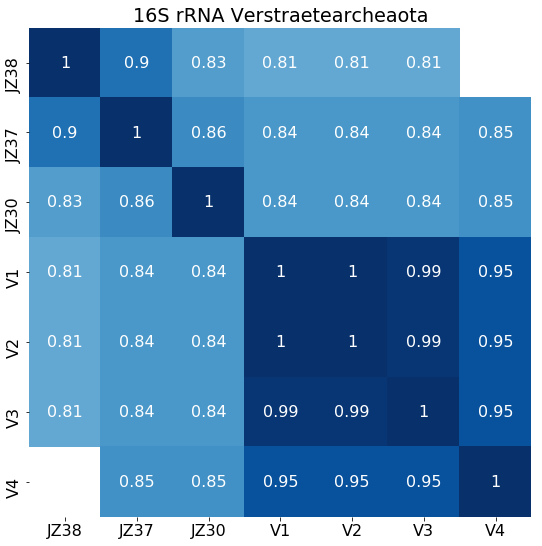

In [522]:
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(9)
order = [6,5,4,0,1,2,3]
sns.heatmap(verst_16Stab.iloc[order,order].fillna(0), cmap='Blues',cbar=False, vmin=0.6,annot=True,mask=(verst_16Stab.iloc[order,order].fillna(0)==0))
plt.ylabel('')
plt.title('16S rRNA Verstraetearcheaota')
plt.show()
f.savefig('MAGs/Analysis/16S_Verstraete/16Sheatmap_Vers.pdf')

In [535]:
verst_16Stab = pd.read_csv('MAGs/Analysis/ANI/16S_ANI lute - ANI.tsv','\t').set_index('Unnamed: 0')
verst_16Stab['Qregion']='full'
verst_16Stab.loc['JZ38','Qregion'] = '1-502'
verst_16Stab.loc['V4','Qregion'] = '890-end'
verst_16Stab

,V1,V2,V3,V4,JZ30,JZ37,JZ38,OP bin 008,OP bin 54,length (bp),Qregion
Unnamed: 0,,,,,,,,,,,
V1,100.00,99.16,82.84,71.79,78.45,68.08,66.36,66.96,70.08,1497.0,full
V2,NaN,100.00,82.95,71.89,78.92,67.91,66.24,66.97,70.47,1497.0,full
V3,NaN,NaN,100.00,71.54,75.80,68.96,66.72,67.19,70.33,1497.0,full
V4,0.95,NaN,NaN,100.00,79.50,67.33,65.98,67.28,71.00,611.0,890-end
JZ30,NaN,NaN,NaN,NaN,100.00,67.33,67.29,68.83,68.09,1502.0,full
JZ37,NaN,NaN,NaN,NaN,NaN,100.00,67.16,68.24,64.76,1500.0,full
JZ38,NaN,NaN,NaN,NaN,NaN,NaN,100.00,73.34,65.54,502.0,1-502
OP bin 008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,68.01,NaN,full
OP bin 54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.00,NaN,full


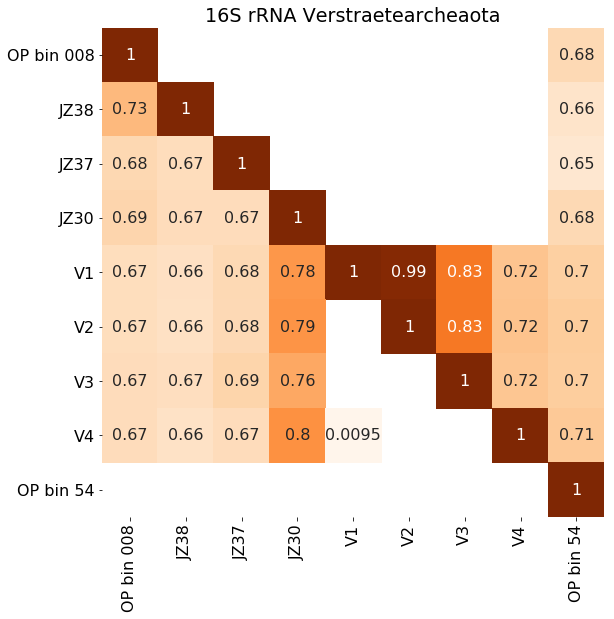

In [538]:
f = plt.figure()
f.set_figwidth(9)
f.set_figheight(9)
order = [7,6,5,4,0,1,2,3,8]
sns.heatmap(verst_16Stab.iloc[order,order].fillna(0).divide(100), cmap='Oranges',cbar=False, vmin=0.6,annot=True,mask=(verst_16Stab.iloc[order,order].fillna(0)==0))
plt.ylabel('')
plt.title('16S rRNA Verstraetearcheaota')
plt.show()
f.savefig('MAGs/Analysis/16S_Verstraete/16Sheatmap_Vers_2.pdf')

In [528]:
verst_16Stab.iloc[order,order]

,JZ38,OP bin 008,JZ37,JZ30,OP bin 54,V1,V2,V3,V4
Unnamed: 0,,,,,,,,,
JZ38,1.00,73.34,0.90,0.83,65.54,0.81,0.81,0.81,NaN
OP bin 008,NaN,1.00,NaN,NaN,68.01,NaN,NaN,NaN,NaN
JZ37,67.16,68.24,1.00,0.86,64.76,0.84,0.84,0.84,0.85
JZ30,67.29,68.83,67.33,1.00,68.09,0.84,0.84,0.84,0.85
OP bin 54,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN
V1,66.36,66.96,68.08,78.45,70.08,1.00,99.16,82.84,71.79
V2,66.24,66.97,67.91,78.92,70.47,1.00,1.00,82.95,71.89
V3,66.72,67.19,68.96,75.80,70.33,0.99,0.99,1.00,71.54
V4,65.98,67.28,67.33,79.50,71.00,0.95,0.95,0.95,1.00
